# Preparation de l'environment de travail

> Connecter à G-Drive pour recupérer la data


In [ ]:
import os
from google.colab import drive
drive.mount("drive/")

Mounted at drive/


> import des packages necessaire

In [ ]:
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

> Decouper les données dans des dossier train test et validation 

In [ ]:
filenames = []
for root, dirname, filename in os.walk('/content/drive/MyDrive/HETIC PFA'):
  filenames.append(filename)
filenames = [item for sublist in filenames for item in sublist]

In [ ]:
os.chdir("/content/drive/MyDrive/HETIC PFA")
data_dir = os.getcwd()
os.mkdir('/content/temp')
os.chdir('/content/temp')
os.mkdir('train')
os.mkdir('valid')
os.mkdir('test')
os.chdir("/content/drive/MyDrive/HETIC PFA")
# Split images (75%/15%/10%) and save to temporary folders:
for subfolder in os.listdir(data_dir):

    # Making a list of all files in current subfolder:
    original_path = f'{data_dir}/{subfolder}'
    original_data = os.listdir(original_path)
    print(original_path)
    # Number of samples in each group:
    n_samples = len(original_data)
    train_samples = int(n_samples * 0.8)
    valid_samples = int(n_samples * 0.9)
        
    train_path = f'/content/temp/train/{subfolder}'
    valid_path = f'/content/temp/valid/{subfolder}'
    test_path = f'/content/temp/test/{subfolder}'
    
    # New class subfolder for training:
    os.chdir('/content/temp/train')
    os.mkdir(subfolder)
    
    # Training images:
    for image, filename in zip(range(train_samples), filenames):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{train_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)
    
    # New class subfolder for validation:
    os.chdir('/content/temp/valid')
    os.mkdir(subfolder)
    
    # Validation images:
    for image in range(train_samples, valid_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{valid_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)
    
    # New class subfolder for testing:
    os.chdir('/content/temp/test')
    os.mkdir(subfolder)
    
    # Test images:
    for image in range(valid_samples, n_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{test_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)

/content/drive/MyDrive/HETIC PFA/AD
/content/drive/MyDrive/HETIC PFA/NAD


>> Nombre total d'images est :

In [ ]:
#@title
print(f"Nombre total d'images est : {len(filenames)}")

Nombre total d'images est : 254


# Première visualisation

> AD -------------> Adjoint
2.   List item



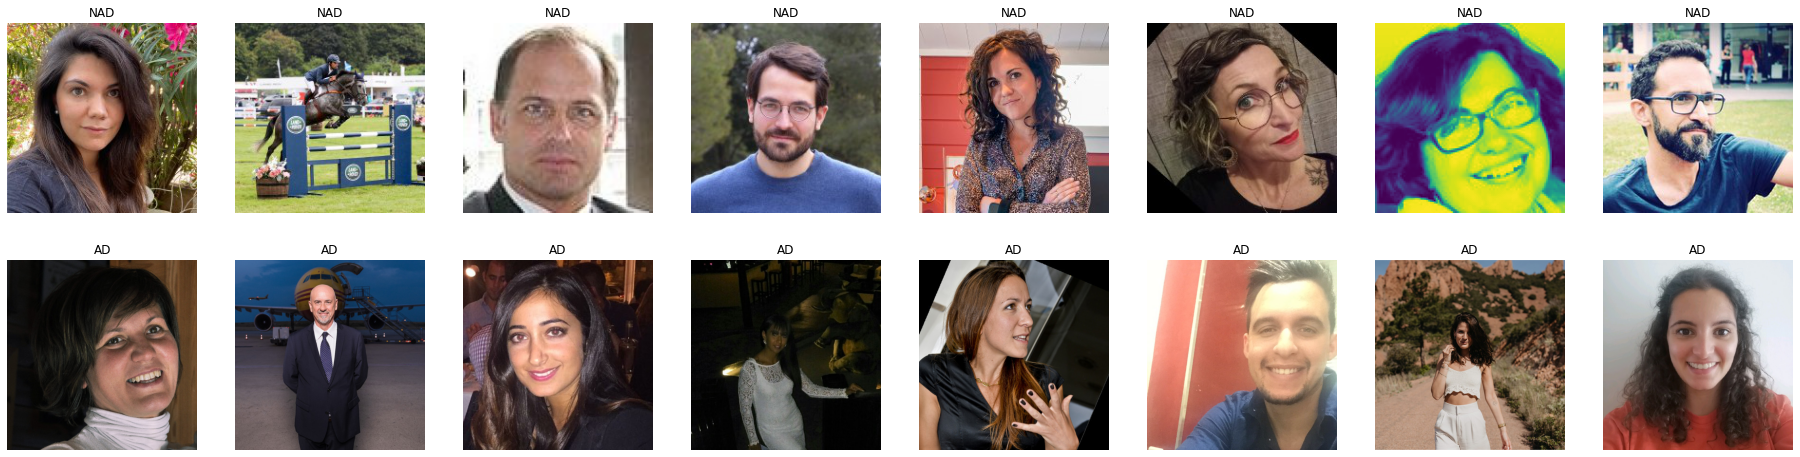

In [ ]:
# Afficher des exemples de chaque classe
nrows = 2
ncols = 8
pos = 0

data_path = os.getcwd()
for subfolder in os.listdir(data_path):
    for i in range(8):
      image_file = os.listdir(os.path.join(data_path, subfolder))[i]
    
      fig = plt.gcf()
      fig.set_size_inches(ncols * 4, nrows * 4)

      pos += 1
      sp = plt.subplot(nrows, ncols, pos)

      cur_image = mpimg.imread(os.path.join(data_path, subfolder, image_file))
      plt.imshow(cur_image)
      plt.title(subfolder)
      plt.axis('Off')

# Première manipulation

## Import des packages necessaires

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2

## Créer des ensembles de données d'images

In [ ]:
os.chdir('/content/')
train_folder = "/content/temp/train"
test_folder = "/content/temp/test"
validation_folder = "/content/temp/valid"
IMG_SIZE = 150
BATCH_SIZE = 32

In [ ]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory=train_folder,
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='binary',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory=validation_folder,
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='binary',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory=test_folder,
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='binary',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

Found 202 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


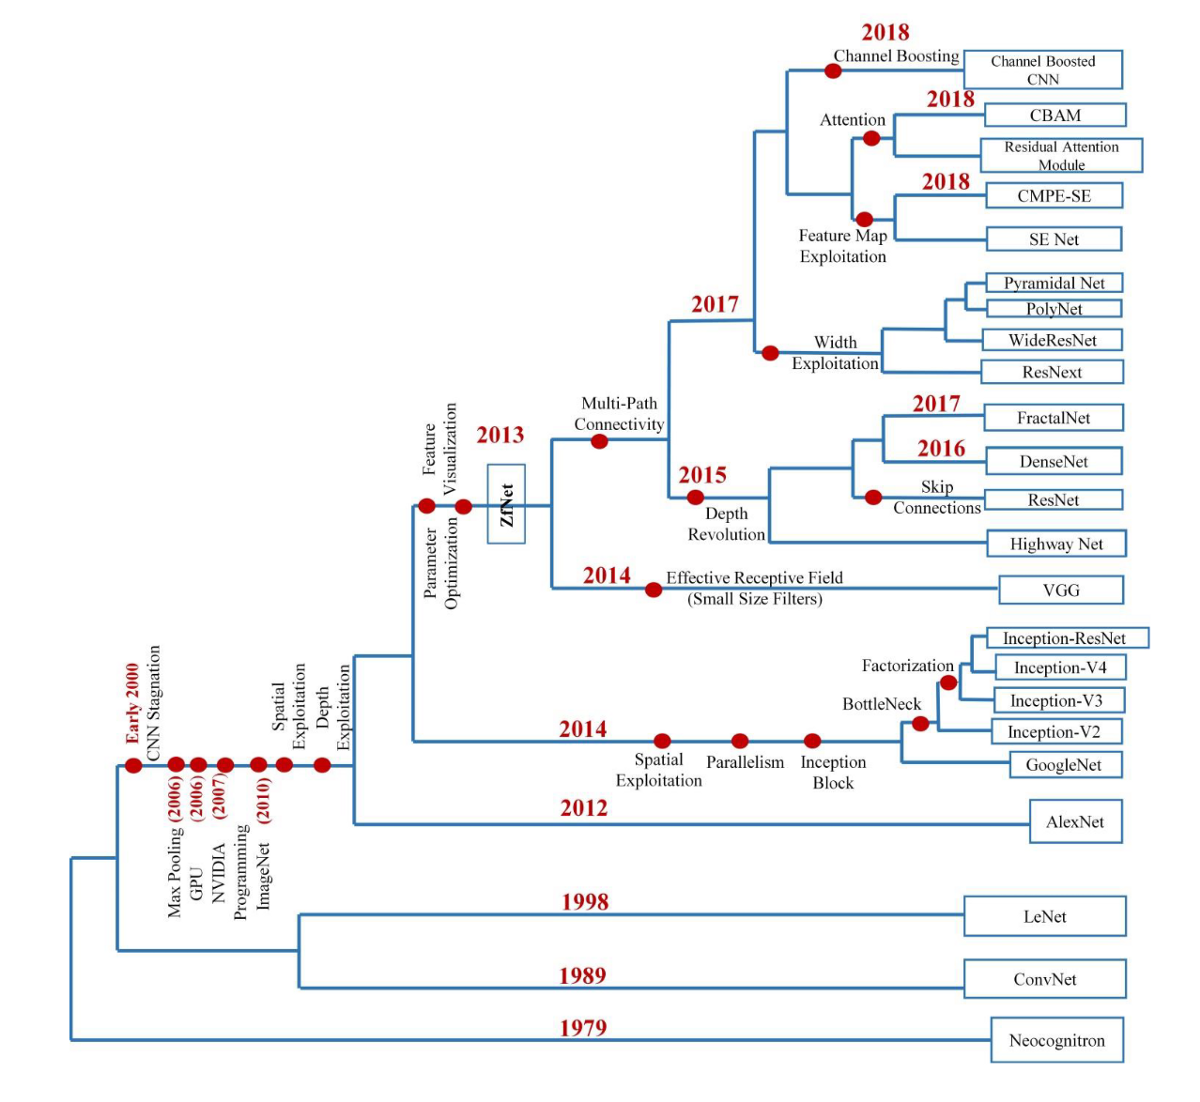

## Création d'un modèle : VGG16

In [ ]:
feature_model = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                     pooling='avg')

feature_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
feature_model.trainable = False

In [ ]:
model = tf.keras.models.Sequential(
    [feature_model,
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(15, activation="relu"),
     tf.keras.layers.Dense(10, activation="relu"),
     tf.keras.layers.Dense(1, activation='sigmoid')
     ]
     )#      tf.keras.layers.Flatten(),

`Binary crossentropy` est choisi comme fonction de perte

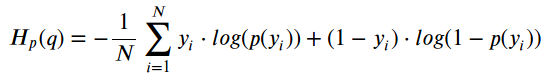

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 15)                7695      
                                                                 
 dense_11 (Dense)            (None, 10)                160       
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 14,722,554
Trainable params: 7,866
Non-trainable params: 14,714,688
_________________________________________________________________


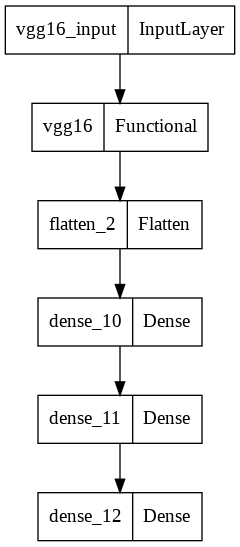

In [ ]:
tf.keras.utils.plot_model(model, "my_first_model.png")

In [ ]:
!pwd

/content


In [ ]:
# Callbacks to be exercised during training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=100,
                    callbacks=[reduce_lr, early_stop],
                    use_multiprocessing=True
                    )#steps_per_epoch=79, validation_steps=16,workers=2


Epoch 1/100
7/7 [==============================] - 4s 489ms/step - loss: 1.2433 - accuracy: 0.5495 - val_loss: 0.5624 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 3s 359ms/step - loss: 0.7917 - accuracy: 0.6188 - val_loss: 0.5872 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 3s 341ms/step - loss: 0.6371 - accuracy: 0.6683 - val_loss: 0.5948 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 3s 346ms/step - loss: 0.5452 - accuracy: 0.7376 - val_loss: 0.5946 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 3s 386ms/step - loss: 0.4763 - accuracy: 0.7723 - val_loss: 0.5943 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 3s 388ms/step - loss: 0.4462 - accuracy: 0.8168 - val_loss: 0.5951 - val_accuracy: 0.6538 - lr: 1.0000e-04
Epoch 7/100
7/7 [==============================] - 2s 335ms/step - loss:

In [ ]:
loss, accuracy = model.evaluate(test_generator,
                                    steps=11, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

11/11 - 5s - loss: 1.3808 - accuracy: 0.4231 - 5s/epoch - 422ms/step
Model performance on test images:
Accuracy = 0.42307692766189575
Loss = 1.3808140754699707


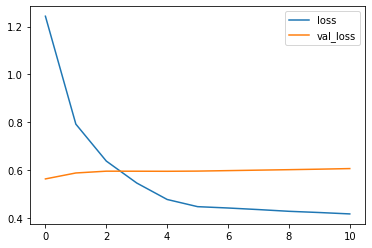

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()